In [896]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

# TODOs (from 09.06.2020)

1. Strip away the non-useful functions
2. Document the remaining functions
3. Move the remaining functions to modules
4. Test the modules
5. Clean up this NB

# Introduction: movement analysis

From a sequence of signaling events, _eg_ GPS measurements, determine locations where the user remains for a significant duration of time, called "stays". For each of these, there should be a beginning and end, as well as a location. 

Generally, this is meant for movement on the surface of the earth, but for present purposes, it is easiest to illustrate in one spatial dimension "1D"; all of the problems and strategies can be generalized to 2D as needed.

**Note** the signaling events for a given user, form a set $\mathcal{E} :=  \{e_i = (\mathbf{x}_i, t_i), i=[0,N-1] \; | \; t_{i+1}>t_i\}$

In [546]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

dsec = 1/3600.0
time = np.arange(0,24,dsec)
stays = [
        get_stay(  0.00,  6.00,-1.00), #home
        get_stay(  7.50, 16.50, 1.00), #work, afternoon
        get_stay( 18.00, 24.00,-1.00)  # overnight
    ]

t_segs, x_segs = get_stay_segs(stays)


raw_journey = get_journey_path(time, get_segments(time, stays, threshold=0.5))


dup_mask = get_mask_with_duplicates(time, 0.05, 0.3)

time_sub = time[dup_mask]
raw_journey_sub = raw_journey[dup_mask]

segments = get_segments(time, stays, threshold=0.5)
new_stays = get_adjusted_stays(segments, time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays)      

noises = get_noise_arr(0.02, 0.15, len(segments))

noise_segments = get_noisy_segs(segments, noises)

noise_journey_sub = get_noisy_path(time_sub, raw_journey_sub, noise_segments)

**Figure** in the above plot, time is on the "x"-axis. An interpretation of this motion, is that the user is initially making a "stay" at a location near $x=-1$, then makes another stay at $x=1$, ending with a return to the initial location. As with all of this data, there is an intrinsic noise that must be considered.

# Goal: Stay detection and positioning

The goal is to identify stays by their beginnings and ends, and associate them to a position. This effectively means to optimally match clusters of points with flat lines.

For a set of events within a cluster $\mathcal{C}_l =  \{e_i \; | \; i = [m,n]_l \subset [0,N-1]\}$, a "flat line" has $|\mathbf{x}_m-\mathbf{x}_n| = 0$. Again, this is easiest to see in 1D but it also holds in 2D.


# Strategy

To find the stays, we consider some requirements.

Firstly, there are two main requirements (previously noted):
1. identify the start/stop of a stay
2. estimate a dominant location, _ie_ the "central location" of the stay
    * this is where the agent spends the majority of the time, _e.g._ within a building, at a park, etc.

Then, there are some minor rquirements:
1. the clusters should contain a minimum number of points
2. the duration between the first and last points should exceed $\Delta t$
3. the clusters should be as long (in time) as possible
    * if there is a sufficient temporal break between two consecutive events without a significant location change, then on must specify how this is to be dealt with.
4. the clusters should contain as many events as possible

One additional requirement which affects all of the above: **cluster outliers should be identified and ignored** 
* outliers can change the central location and also the beginning/ending of the clusters
* from the calculation of the central location
    * counting them could still help in identifying a cluster wihtout using their position
    
All of these must be considered together.

This clearly defines an optimization problem: 
* maximize the length of the fit line, while 
    * mimimizing its error by adjusting its position ($\mathrm{x}_{\mathrm{opt.}}$) and end-regions ($t_{\mathrm{start}}, t_{\mathrm{stop}}$)
    * ignoring the outliers.

**Notes** 

* When the error is the mean squared error: $\epsilon := \sqrt{ \frac{1}{N}\sum^N_i(\mathrm{x}_i-\mathrm{x}_{\mathrm{opt.}})^2}$; 
    * this simplifies the position since the mean (or "centroid") is the value of $\mathrm{x}_{\mathrm{opt.}}$ which minimizes this error, leaving only the adjustment of the end-regions and outliers for the optimization task.

This suggests that there is at least a solution to this problem: 
One could consider all possible combinations of subsequences and all possible combinations of their outliers, and measure error, and then pick any from the set of lowest error subsequence-outlier combination fits. However, this is similar to the maximum subarray problem, and in the worst case it would be $\mathcal{O}(n^3)$.

It's countably finite, but impractical approach; itcan be a benchmark to compare all other algorithms which aim to do the same within some acceptable error.

### The Box

In [547]:
eps = 0.25

In [548]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

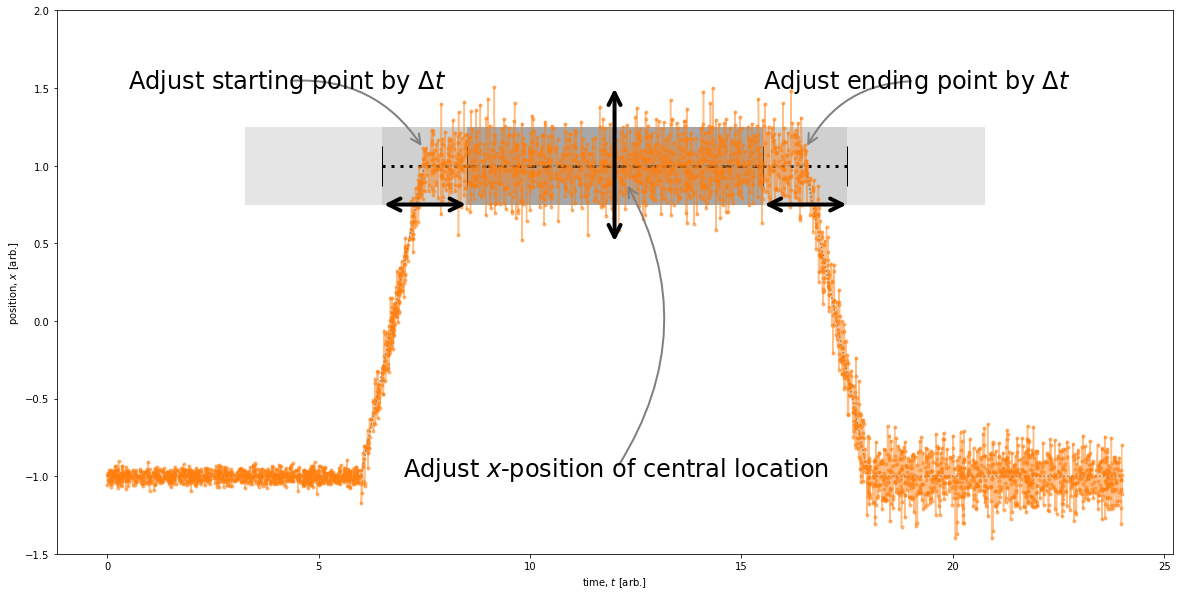

In [549]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

begin = t_segs[3]+1
begin_buff = begin-2
end = t_segs[4]-1
end_buff = end+2

loc = x_segs[3]


rect_inner = Rectangle((begin, loc-eps), end-begin, 2*eps)
rect_outer = Rectangle((begin_buff, loc-eps), end_buff-begin_buff, 2*eps)
rect_outer2 = Rectangle((begin_buff/2, loc-eps), end+(begin-begin_buff), 2*eps)

# The adjusted rwa-stays
#plt.plot(t_segs, x_segs, '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot([begin,end], [loc,loc], 'k--', dashes=[3,2], linewidth=3.0)

ax.plot([begin_buff,begin], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)
ax.plot([end,end_buff], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)

#plt.plot(t_segs[3:5], x_segs[3:5], '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot(time_sub, raw_journey_sub, ':', label='raw journey')
ax.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)




rect_inner = Rectangle((begin, loc-eps), end-begin, 2*eps)
rect_outer = Rectangle((begin_buff, loc-eps), end_buff-begin_buff, 2*eps)
rect_outer2 = Rectangle((begin_buff/2, loc-eps), end+(begin-begin_buff), 2*eps)

# Create patch collection with specified colour/alpha
pc = PatchCollection([rect_outer2], \
                     facecolor='gray', alpha=0.2, edgecolor='k',linewidth=0)
# Create patch collection with specified colour/alpha
pc1 = PatchCollection([rect_outer], \
                     facecolor='gray', alpha=0.2, edgecolor='k',linewidth=0)

pc2 = PatchCollection([rect_inner], \
                     facecolor='gray', alpha=0.5, edgecolor='k',linewidth=0)


# Add collection to axes
ax.add_collection(pc)
ax.add_collection(pc1)
ax.add_collection(pc2)


# interface tracking profiles
arrowprops=dict(arrowstyle="<->", 
                shrinkA=0.5,
                mutation_scale=30.0,
                connectionstyle="arc3", linewidth=4.0)
# the arrows
arrowcentery = 1.0
arrowcenterx = 12
arrowcenterh = 0.5
ax.annotate("", xy=(arrowcenterx, arrowcentery-arrowcenterh), xytext=(arrowcenterx, arrowcentery+arrowcenterh),
             arrowprops=arrowprops)

dt_arrowcentery = 0.25
ax.annotate("", xy=(begin_buff, arrowcentery-dt_arrowcentery), xytext=(begin, arrowcentery-dt_arrowcentery),
             arrowprops=arrowprops)

ax.annotate("", xy=(end, arrowcentery-dt_arrowcentery), xytext=(end_buff, arrowcentery-dt_arrowcentery),
             arrowprops=arrowprops)


mid_point = lambda x1,x2: 0.5*(x1+x2)

delta_t_texty = 1.5
ax.annotate(r"Adjust starting point by $\Delta t$", fontsize=24.0,
            xy=(mid_point(begin,begin_buff), 1.1), xycoords='data',
            xytext=(begin-8,delta_t_texty), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="0.5",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=-0.3", linewidth=2.0
                            ),
            )
ax.annotate(r"Adjust ending point by $\Delta t$", fontsize=24.0,
            xy=(mid_point(end,end_buff), 1.1), xycoords='data',
            xytext=(end, delta_t_texty), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="0.5",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=0.3", linewidth=2.0
                            ),
            )

ax.annotate(r"Adjust $x$-position of central location",fontsize= 24,
            xy=(arrowcenterx+0.25, arrowcentery-0.1), xycoords='data',
            xytext=(arrowcenterx-5, arrowcentery-2.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="0.5",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=0.3", linewidth=2.0
                            ),
            )

'''plt.text(0, 0.1, r'$\delta$',
         {'color': 'black', 'fontsize': 24, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
'''
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.5, 2)
plt.grid(visible=False);

Once the box (width is provided by the spatial tolerance) is positioned in a good way (_ie_ the centroid), extending the box forwards or backwards in time makes no change to the _score_ of the box.

Here, the score could be something like the number of points, the std/MSE; whatever it is, it should be saturated at some point and extending the box makes no difference, meaning that something converges which provides a stopping criterion. 

### Box method

In [550]:
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

## From here

In [551]:
from stay_classification.box_method import asymm_box_method_modular
from stay_classification.box_method import get_thresh_duration, get_slope

0.5 6.202222222222223 1 1161
6.25 1.3438008611884393
7.25 1.3438008611884393
7.75 9.625277777777779 1363 2988
17.0 -1.2073016525690423
17.5 -1.3733710513734538
18.0 6.302500000000002 3141 4317


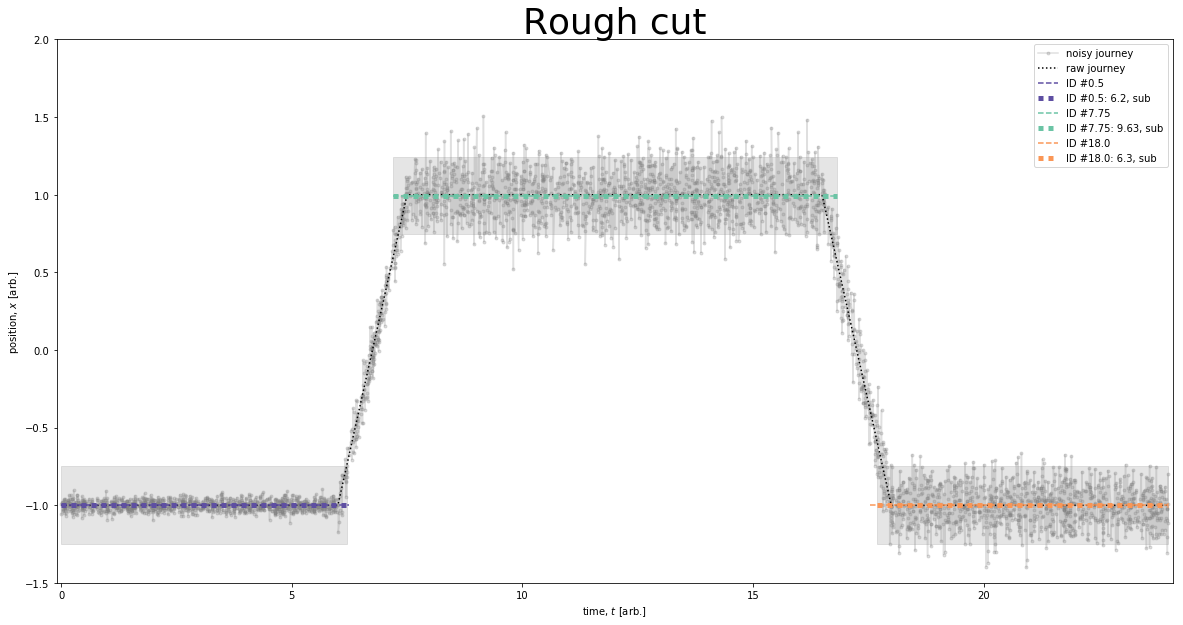

In [552]:
eps = 0.25
time_thresh = 5/12

long_time_thresh = 1.0
slope_thresh = 1.0
count_thresh = 50

min_t, max_t = 0.5, 23.5


fig, ax = plt.subplots(1,1,figsize=(20,10))

# The adjusted rwa-stays
#plt.plot(t_segs, x_segs, '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot(time_sub, raw_journey_sub, ':', color='k', label='raw journey')
#ax.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

last_ind = 0

nnn = 0
for timepoint in np.arange(min_t,max_t,0.25):

    if timepoint < time_sub[last_ind]:
        continue    
    
    mean, start_ind, last_ind = asymm_box_method_modular(time_sub,time_thresh,noise_journey_sub,eps,timepoint)
    
    if time_sub[last_ind]-time_sub[start_ind] < time_thresh:
        continue
        
    t0, t1 = get_thresh_duration(eps, mean)(noise_journey_sub[start_ind:last_ind],start_ind)        
    if time_sub[t1]-time_sub[t0] < time_thresh:
        continue  

    # If the stay is less than 1 hour, check the slope of the segement
    if time_sub[t1]-time_sub[t0] < long_time_thresh:         
        xdata = time_sub[t0:t1]
        ydata = noise_journey_sub[t0:t1]
        slope = get_slope(xdata, ydata)
        print(timepoint, slope)
        if abs(slope) > slope_thresh: 
            continue     
        
    #print(timepoint,":", mean, start_ind, last_ind)        
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean], '--', color=colors[nnn], label=f'ID #{timepoint}')
    
    t_diff = abs(time_sub[t1]-time_sub[t0])
    ax.plot([time_sub[t0],time_sub[t1]], [mean,mean], '--', \
            dashes=[1,1], linewidth=5, color=colors[nnn], \
            label=f'ID #{timepoint}: {round(t_diff,2)}, sub')
    
    # Add the box
    rect_color = "gray" #colors[nnn]
    rect = Rectangle((time_sub[t0], mean-eps), t_diff, 2*eps)
    pc = PatchCollection([rect], \
                         facecolor=rect_color, alpha=0.2, edgecolor=rect_color,linewidth=1)
    ax.add_collection(pc)

    print(timepoint, t_diff,t0,t1)
    nnn += 1
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.5, 2)

#plt.xlim(min_t, max_t)
plt.xlim(-0.1, 24.1)
#plt.xlim(15.1, 19.1)

plt.title('Rough cut', fontsize=36)
plt.grid(visible=False);
plt.legend();

In [553]:
rand_range = lambda size, max_, min_: (max_-min_)*np.random.random_sample(size=size) + min_

In [554]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

In [555]:
from synthetic_data.trajectory_class import get_trajectory

In [556]:
dsec = 1/3600.0
time = np.arange(0,24,dsec)

0.002914221692034853 0.1473667181056486


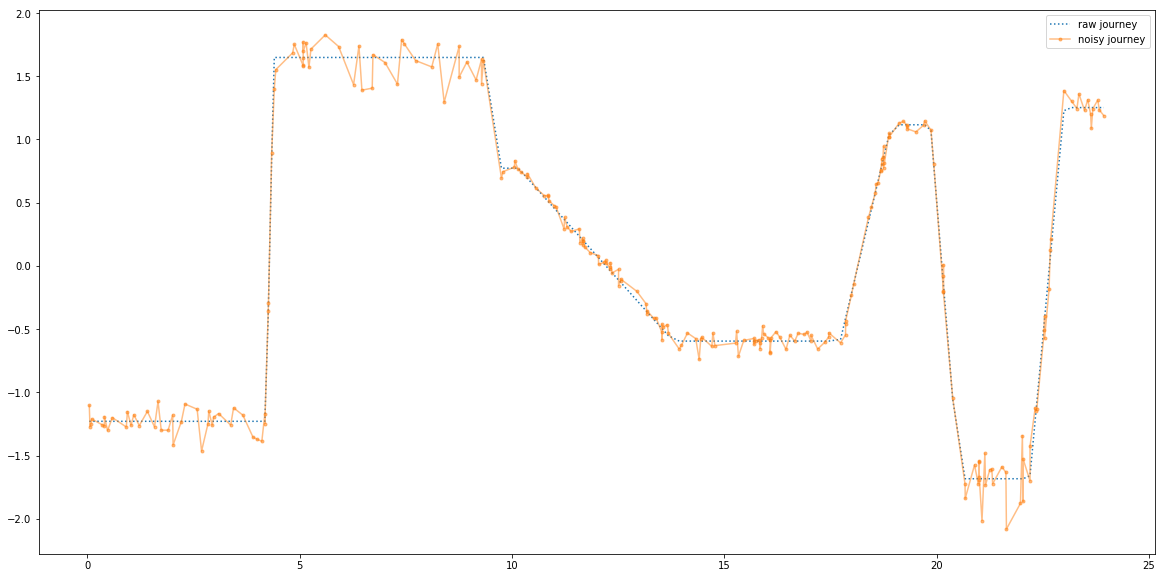

In [561]:
event_frac = rand_range(1,0.01,0.001)[0]

duplicate_frac = rand_range(1,0.3,0.05)[0]

print(event_frac, duplicate_frac)

configs = {
    'threshold':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}


nr_stays = np.random.randint(10)
stay_time_bounds = np.concatenate((np.array([0]),rand_range(2*nr_stays, 24, 0),np.array([24])))
stay_time_bounds = np.sort(stay_time_bounds)
stay_xlocs = rand_range(nr_stays+1, 2, - 2.0)

stays = []
for n in range(nr_stays+1):
    
    nn = 2*n
    stay = get_stay(stay_time_bounds[nn], stay_time_bounds[nn+1],  stay_xlocs[n])
    #print(n,nn,nn+1,stay)
    stays.append(stay)
    

time_sub, raw_journey_sub, noise_journey_sub = get_trajectory(stays, time, configs)

segments = get_segments(time, stays, threshold=0.5)
new_stays = get_adjusted_stays(segments, time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays) 

plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

#plt.plot(new_t_segs, new_x_segs, 'ko--', linewidth=3.0, markerfacecolor='w', markersize=4.0, markeredgewidth=1.0, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)
plt.legend();
#plt.xlim([6.2,6.6]);

In [68]:
# DONE
def get_thresh_duration2(eps, mean):
    
    # TODO: this fails when sub_arr.size = 0
    upper = mean+eps
    lower = mean-eps
    
    def meth(sub_arr, start):
        
        mask =  np.where((sub_arr < upper) & (sub_arr > lower))[0] + start
        #print(mask)
    
        return mask.min(), mask.max(0)
        
    return meth

In [158]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [912]:
segs_plot_kwargs = {'linestyle':'--', 'marker':'o', 'color':'k', 'linewidth':4.0, 'markerfacecolor':'w', 'markersize':6.0, 'markeredgewidth':2.0}

### Debugging: when there is no thresh. mean

In [108]:
from stay_classification.box_method import extend_box, get_thresh_mean
from stay_classification.checks import check_means

In [831]:
#DONE
def bug_get_converged(converged, means, indices, count_thresh, time_diff, time_thresh=0.5):
    
    # Originally, there were a few conditions for convergence -. moved to "extend_box"
    '''
    print("BGC:",indices[0],indices[-1],len(indices))
    # If it converged early, get the converged results;
    if converged:  & ((len(indices)>count_thresh) | ((time_diff>time_thresh) & (len(indices)>10))):
        index = min(len(indices), count_thresh)        
        last_mean = means[-index]
        last_index = indices[-index]
    '''
    # If it converged early, get the converged results;
    if converged:
        last_mean = means[-1]
        last_index = indices[-1]
    else:
        # else, get the boundary value
        last_mean = means[-1]
        last_index = indices[-1] 
    
    return last_mean, last_index

In [196]:
embedded = lambda t0,t1,pair: ((t0 >= pair[0]) & (t0 <= pair[1]) | (t1 >= pair[0]) & (t1 <= pair[1]))

In [978]:
# DONE
def get_time_ind(t_arr, timepoint, time_thresh, direction):
    
    index = np.where((time_sub < (timepoint)) & \
                 (time_sub > (timepoint-2*time_thresh)))
    n = 2
    while index[0].size == 0:
        index = np.where((time_sub < (timepoint)) & \
                 (time_sub > (timepoint + direction*n*time_thresh)))
        n+=1
        
    if direction == 1:
        return index[0].max() 
    else: 
        return index[0].min()         

In [848]:
# DONE
def bbug_extend_box(t_arr, x_loc, working_index, fixed_index, means, count_thresh = 50):

    
    keep_running = (working_index > 1) & (working_index < len(x_loc)-1)
    
    indices = []
    
    if working_index < fixed_index: 
        # Go backwards in time
        direction = -1
    else: 
        # Go forwards in time
        direction = 1
        
    mean = means[-1]
    converged_mean = mean
    converged_mean_ind0 = working_index
    while keep_running:
        #print(mean, direction)
        # Update and store the working index
        working_index += direction*1
        indices.append(working_index)
        
        # Update and store the mean
        if direction == -1:
            mean = get_thresh_mean(eps,mean)(x_loc[working_index:fixed_index])
        else:
            mean = get_thresh_mean(eps,mean)(x_loc[fixed_index:working_index])
        
        means.append(mean)    
        
        if np.isnan(mean):
            #print(mean)
            break
            
        
        # Stopping criteria:
        # if the thresholded mean doesn't change upon getting new samples
        # * if the duration is too long and there are sufficient number of samples
        
        if mean != converged_mean:
            converged_mean = mean
            converged_mean_ind = working_index
            converged_mean_ind0 = working_index
        else:
            converged_mean_ind = working_index
        
        time_diff = abs(t_arr[fixed_index]-t_arr[working_index])
        ctime_diff = abs(t_arr[converged_mean_ind0]-t_arr[converged_mean_ind])                                                         
        if ((ctime_diff>1.0) & (mean == converged_mean)): 
            print('cdrop',ctime_diff)
            break        
        
        
        # When the mean either converges or stops
        if ((len(indices)>count_thresh) | ((time_diff>0.5) & (len(indices)>5))):  
            #print(time_diff,len(indices))
            nr_events = min(len(indices), count_thresh)
            # see also: bug_check_means(means,nr_events,0.25)
            if check_means(means,nr_events):
                print('drop',time_diff)
                break       
                    
                    
        #print(f"{t_arr[working_index]:.3f} {time_diff:.3f} {ctime_diff:.3f}", \
        #      len(indices), fixed_index, working_index, converged_mean_ind0, converged_mean_ind, \
        #      f"\t{mean:.5f} {x_loc[working_index]:.3f} {mean+eps:.5f}",)#,[m == m0 for m in means[-count_thresh:]])            
                    
        keep_running = (working_index > 1) & (working_index < len(x_loc)-1)

    return means, indices, keep_running

~~`get_thresh_duration`~~ $\to$ `get_bounded_indices` in `box_classifier.py`  **TODO** check args!

~~`extend_box`~~

~~`get_counts`~~ $\to$ `get_bounded_indices` in `box_classifier.py` 
**TODO** check args!

~~`get_thresh_mean`~~

~~`get_converged`~~

`get_slope`$\to$ `get_slope` in `box_classifier.py` 

New:<br/>
1. $\checkmark$ ~~`bug_asymm_box_method_modular`~~ $\to$ `make_box`
    * $\checkmark$ ~~`get_time_ind`~~
    * $\checkmark$ ~~`bbug_extend_box`~~
    * $\checkmark$ ~~`bug_get_converged`~~
    
2. $\checkmark$ ~~`bbug_extend_box`~~ $\to$ `extend_edge`
    *  $\checkmark$ ~~`get_thresh_mean`~~
    * $\checkmark$ ~~`check_means`~~

In [991]:
# DONE
def bug_asymm_box_method_modular(t_arr, time_thresh, x_loc, eps, timepoint, count_thresh = 50, verbose=False):
        
       
    # 1. Initialization
    # 1.1. Init and store the start, end points from the timepoint
    if verbose: print(f"\t1.  {timepoint-time_thresh:.3f} < {timepoint:.3f} < {timepoint+time_thresh:.3f}") 
    start = get_time_ind(t_arr, timepoint, time_thresh, -1)
    end   = get_time_ind(t_arr, timepoint, time_thresh, 1)    

    starts, ends = [], []
    starts.append(start)
    ends.append(end)
    
    # 1.2. Initialize and store the mean for the region
    mean = np.mean(x_loc[start:end])
    means = [mean]
    
    
    # 2. Extend the box in the backwards direction    
    # 2.1. Extension phase
    if verbose: print(f"\t2.   {mean:.4f} {start:4d} {end:4d}")    
    means, indices, keep_running = bbug_extend_box(t_arr, x_loc, start, end, means)
    
    # 2.2. Check if NAN --> TODO: check why this happens! 
    if verbose: print(f"\t2.1. {mean:.4f} {start:4d} {end:4d}", keep_running)                     
    if np.isnan(means[-1]):
        if verbose: print(f"\t2.1. \t\tDrop {means[-1]:.4f} {starts[-1]:4d}", end)
        return means[-1], starts[-1], end    
    starts += indices
    
    # 2.3. If it converged early, get the converged results;    
    if verbose: print(f"\t2.2. {means[-1]:.4f} {starts[-1]:4d} {end:4d}")     
    tdiff = t_arr[end]-t_arr[starts[0]]
    mean, start = bug_get_converged(keep_running, means, starts, count_thresh, tdiff)
    
    # 2.4. Additional check if NAN
    if np.isnan(mean):
        if verbose: print(f"\t2.3. \t\tDrop {means[-1]:.4f} {starts[-1]:4d} {end:4d}")
        return means[-1], starts[-1], end
    
    
    # 3. Extend the box in the forwards direction       
    # 3.1. Extension phase
    if verbose: print(f"\t3.   {mean:.4f} {start:4d} {end:4d}", keep_running)     
    means, indices, keep_running = bbug_extend_box(t_arr, x_loc, end, start, means)
        
    # 3.2. Check if NAN --> TODO: check why this happens! 
    if verbose: print(f"\t3.1. {mean:.4f} {start:4d} {end:4d}", keep_running)                     
    if np.isnan(means[-1]):
        if verbose: print(f"\t3.1. \t\tDrop {means[-1]:.4f} {start:4d} {ends[-1]:4d}")
        return means[-1], start, ends[-1]
    ends += indices   
     
    # 3.3. If it converged early, get the converged results
    if verbose: print(f"\t3.1. {means[-1]:.4f} {start:4d} {end:4d}", keep_running) 
    tdiff = t_arr[ends[-1]]-t_arr[start]
    mean, end = bug_get_converged(keep_running, means, ends, count_thresh, tdiff)

    # 2.4. Additional check if NAN
    if np.isnan(mean):
        if verbose: print(f"\n\t3.3. \t\tDrop {means[-1]:.4f} {start:4d} {ends[-1]:4d}")
        return means[-1], start, ends[-1]
    
    
    # 4
    if verbose: print(f"\t4.   {mean:.4f} {start:4d} {end:4d}") 
        
    return mean, start, end

In [850]:
def time_overlap(t0,t1,tt0,tt1):
    
    if ((t0>=tt0)&(t0<tt1)):
        return True
    elif ((t1>=tt0)&(t1<tt1)):
        return True
    elif ((t0 <= tt0) & (tt1 <= t1)):
        return True
    else:
        return False

In [857]:
def bug_get_slope(eps, mean):
    
    upper = mean+eps
    lower = mean-eps
    
    def meth(t_subarr, x_subarr):
        
        mask =  np.where((x_subarr < upper) & (x_subarr > lower))
        
        ub_xdata = t_subarr[mask] - t_subarr[mask].mean()
        ub_ydata = x_subarr[mask] - x_subarr[mask].mean()
        
        return (ub_xdata.T.dot(ub_ydata))/(ub_xdata.T.dot(ub_xdata))
        
    return meth

In [957]:
def check_true(t_s, t_l, tsegs):
    for t_1, t_2 in zip(tsegs.tolist()[::3],tsegs.tolist()[1::3]):
        if time_overlap(t_s, t_l, t_1, t_2 ): 
            return t_1, t_2

### Run

In [ ]:
configs = {
    'eps':0.25,
    'time_thresh':5/12,
    'long_time_thresh':1.0,
    'slope_thresh':0.50,
    'count_thresh':50
}


Start at 0.100, dt = 0.836, 0, 1
	1.  -0.317 < 0.100 < 0.517
	2.   -1.2085    0    3
	2.1. -1.2085    0    3 False
	2.2. -1.2085    0    3
	3.   -1.2085    0    3 False
cdrop 1.0075000000000003
	3.1. -1.2085    0    3 True
	3.1. -1.2341    0    3 True
	4.   -1.2341    0   52
0 52 0 37

PLOT: ID #  0 - - - - - - - - - - - - - - - - - - - - - - - -
	0.100 0, 37 True: ; Pred: 0.043, 4.178 -1.234 


Start at 4.350, dt = 4.135, 0, 37
	1.  3.933 < 4.350 < 4.767
	2.   -1.0452   32   40
	2.1. -1.0452   32   40 False
	2.2. -1.2376    1   40
	3.   -1.2376    1   40 False
drop 5.022222222222222
	3.1. -1.2376    1   40 True
	3.1. -1.2376    1   40 True
	4.   -1.2376    1   46
1 46 1 37
			Embedded, skip

Start at 5.100, dt = 4.135, 1, 37
	1.  4.683 < 5.100 < 5.517
	2.   1.5417   40   49
drop 1.0872222222222225
	2.1. 1.5417   40   49 True
	2.2. 1.6229   34   49
	3.   1.6229   34   49 True
cdrop 1.0147222222222219
	3.1. 1.6229   34   49 True
	3.1. 1.6209   34   49 True
	4.   1.6209   34   84
34 84 

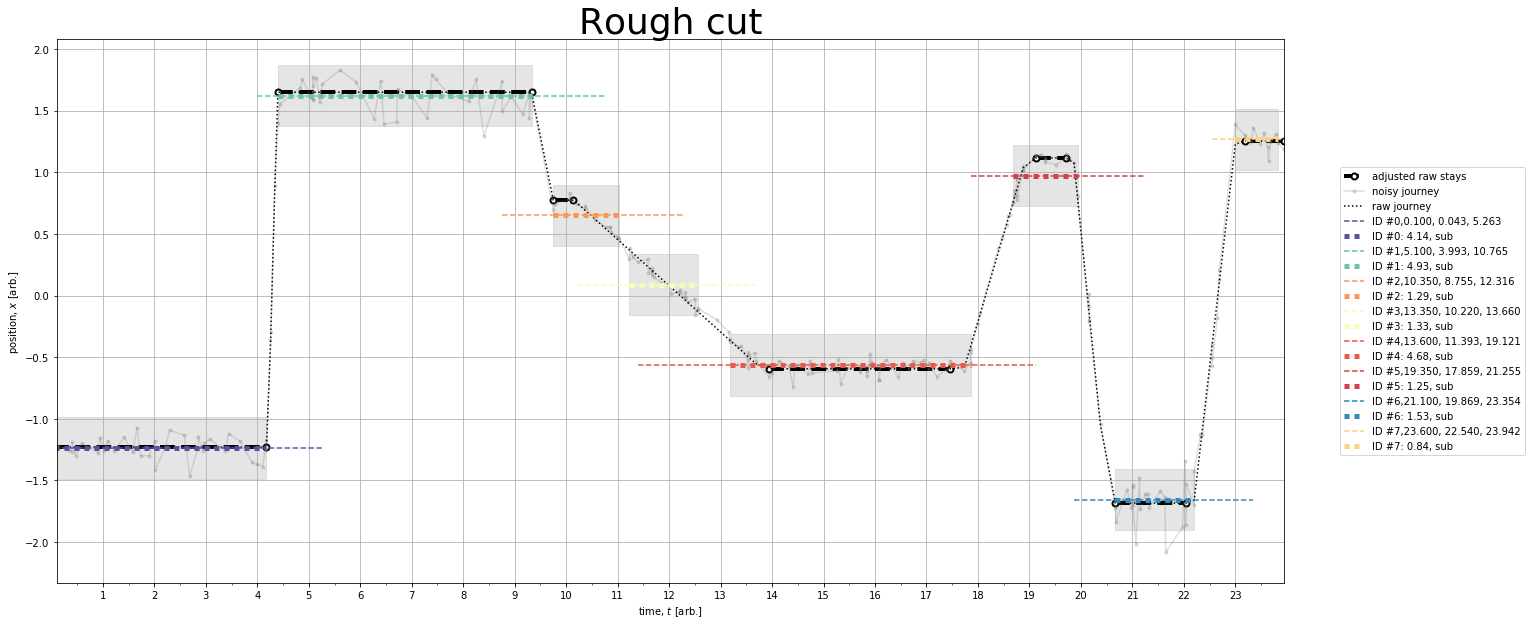

In [992]:
eps = configs['eps']
time_thresh = configs['time_thresh']
long_time_thresh = configs['long_time_thresh']  
slope_thresh = configs['slope_thresh']
count_thresh = configs['count_thresh']


min_t, max_t = 0.1, 23.95


fig, ax = plt.subplots(1,1,figsize=(22,10))

# The adjusted raw-stays
plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
ax.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot(time_sub, raw_journey_sub, ':', color='k', label='raw journey')

t0,t1 = 0,1
start_ind, last_ind = t0, t1

pairs = []

nnn = 0

for timepoint in np.arange(min_t,23.95,0.25):
   
    # If the current timepoint is less than the last box-end, skip ahead
    # TODO: this is useful but possibly, without refinement, misses some stays 
    # HOWEVER: without it, it doesn't work!
    if (time_sub[start_ind] <= timepoint) & (timepoint <= time_sub[last_ind]):
        #print("\t\t\talready processed, skip")                
        continue    
    else:
        print(f"\nStart at {timepoint:.3f}, dt = {t_diff:.3f}, {t0}, {t1}")  
    
    # Process the time point
    mean, start_ind, last_ind = bug_asymm_box_method_modular(\
        time_sub,time_thresh,noise_journey_sub,eps,timepoint, 50, True)
    
    # Drop if a NAN was encountered --. failed to find a mean
    if np.isnan(mean):
        print("\t\t\tmean = NaN, skip")
        continue
        
    # If the duration of the stay is too small, skip ahead
    if time_sub[last_ind]-time_sub[start_ind] < time_thresh:
        print("\t\t\ttoo short, skip")        
        continue
    
    # If the duration due to the thresholded box is too short, skip ahead
    #print(start_ind,last_ind,mean)
    t0, t1 = get_thresh_duration2(eps, mean)(noise_journey_sub[start_ind:last_ind],start_ind)    
    #t0, t1 = get_thresh_duration(eps, mean)(noise_journey_sub[start_ind:last_ind],start_ind)  
    print(start_ind,last_ind,t0, t1)
    if time_sub[t1]-time_sub[t0] < time_thresh:
        print("\t\t\talso too short, skip")        
        continue  

    # If the stay is less than 1 hour, check the slope of the segement --> This isn't watertight
    if time_sub[t1]-time_sub[t0] < long_time_thresh:         
        xdata = time_sub[t0:t1]
        ydata = noise_journey_sub[t0:t1]
        slope = bug_get_slope(eps, mean)(xdata, ydata)
        print(f"\tAt {timepoint:.3f}, slope = {slope:.3f}")
        if abs(slope) > slope_thresh: 
            print("\t\t\tslope is too big, skip")
            continue     
    # If the stay is less than 2 hour, check the slope of the segement
    if time_sub[t1]-time_sub[t0] < 2*long_time_thresh:                
        xdata = time_sub[t0:t1]
        ydata = noise_journey_sub[t0:t1]
        slope = bug_get_slope(eps, mean)(xdata, ydata)
        print(f"\tAgain, at {timepoint:.3f}, slope = {slope:.3f}")
        if abs(slope) > slope_thresh: 
            print("\t\t\tAgain, slope is too big, skip")
            continue         
    
    # If the stay is embedded with other stays --> This is tricky!
    if any([embedded(t0,t1, p) for p in pairs] + [embedded(p[0],p[1],[t0,t1]) for p in pairs]):
        print("\t\t\tEmbedded, skip")   
        continue
    
    # PLOTTING
    dashing = "-"+23*" -"
    ddashing = "="+30*"=="
    
    t_start = time_sub[t0]
    t_last = time_sub[t1]
    
    '''seg_ind = min(3*nnn+1,len(new_t_segs))
    t_seg_0 = new_t_segs[seg_ind-1]
    t_seg_1 = new_t_segs[seg_ind]'''
    #t_seg_0, t_seg_1 = check_true(t_start, t_last, new_t_segs)
    true_vals = ""
    '''if time_overlap(t_start, t_last, t_seg_0, t_seg_1 ):
        true_vals = f'{t_seg_0:2.3f}, {t_seg_1:2.3f}'    
    else:
        true_vals = 'Unmatched'
    '''
    true_vals = f"True: {true_vals};"

    print(f'\nPLOT: ID #{nnn:3d} {dashing}\n\t{timepoint:.3f}', \
          f'{t0}, {t1}', \
          true_vals,\
          f'Pred: {t_start:.3f}, {t_last:.3f}',\
          f'{mean:.3f}', \
          f'\n\n{ddashing}')
    #print(timepoint,":, mean, start_ind, last_ind)        
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean],\
            '--', color=colors[nnn], \
            label=f'ID #{nnn},{timepoint:.3f}, {time_sub[start_ind]:.3f}, {time_sub[last_ind]:.3f}')
    
    t_diff = abs(time_sub[t1]-time_sub[t0])
    ax.plot([time_sub[t0],time_sub[t1]], [mean,mean], '--', \
            dashes=[1,1], linewidth=5, color=colors[nnn], \
            label=f'ID #{nnn}: {round(t_diff,2)}, sub')
    
    # Add the box
    rect_color = "gray" #colors[nnn]
    rect = Rectangle((time_sub[t0], mean-eps), t_diff, 2*eps)
    pc = PatchCollection([rect], \
                         facecolor=rect_color, alpha=0.2, edgecolor=rect_color,linewidth=1)
    ax.add_collection(pc)

    #print(f"End At {timepoint:.3f}, dt = {t_diff:.3f}, {t0}, {t1}")   
    pairs.append([t0,t1])
    start_ind, last_ind = t0, t1
    nnn += 1
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_journey_sub.min()-1*eps
ymax = noise_journey_sub.max()+1*eps
plt.ylim(ymin, ymax)


ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(min_t, max_t)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

plt.title('Rough cut', fontsize=36)
plt.grid(visible=True);
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right', ncol=1);

**Note** 
* a box will extend too _far_ when
    * if the duration of constant mean is too long, 
    * if the number of events for a constant mean is too large
        * **!** need to consider numbers of samples because the samples can increase but time-delta not
* a box will cut too _early_ when
    * if the number of events for a temporal constant mean is too large


### Run2


Start at 0.100, dt = 4.927, 0, 1
	1.  -0.317 < 0.100 < 0.517
	2.   -1.2085    0    3
	2.1. -1.2085    0    3 False
	2.2. -1.2085    0    3
	3.   -1.2085    0    3 False
cdrop 1.0075000000000003
	3.1. -1.2085    0    3 True
	3.1. -1.2341    0    3 True
	4.   -1.2341    0   52
0 52 0 37

PLOT: ID #  0 - - - - - - - - - - - - - - - - - - - - - - - -
	0.100 0, 37 True: 0.043, 4.178; Pred: 0.043, 4.178 -1.234 


Start at 4.594, dt = 4.135, 0, 37
	1.  4.178 < 4.594 < 5.011
	2.   -0.5432   33   42
drop 1.4972222222222218
	2.1. -0.5432   33   42 True
	2.2. -0.3257   27   42
	3.   -0.3257   27   42 True
drop 2.1422222222222222
	3.1. -0.3257   27   42 True
	3.1. -0.3257   27   42 True
	4.   -0.3257   27   48
27 48 38 39
			also too short, skip
			 5.097 already processed, skip

Start at 5.097, dt = 4.135, 38, 39
	1.  4.680 < 5.097 < 5.513
	2.   1.5417   40   49
drop 1.0872222222222225
	2.1. 1.5417   40   49 True
	2.2. 1.6229   34   49
	3.   1.6229   34   49 True
cdrop 1.0147222222222219
	3.1. 1

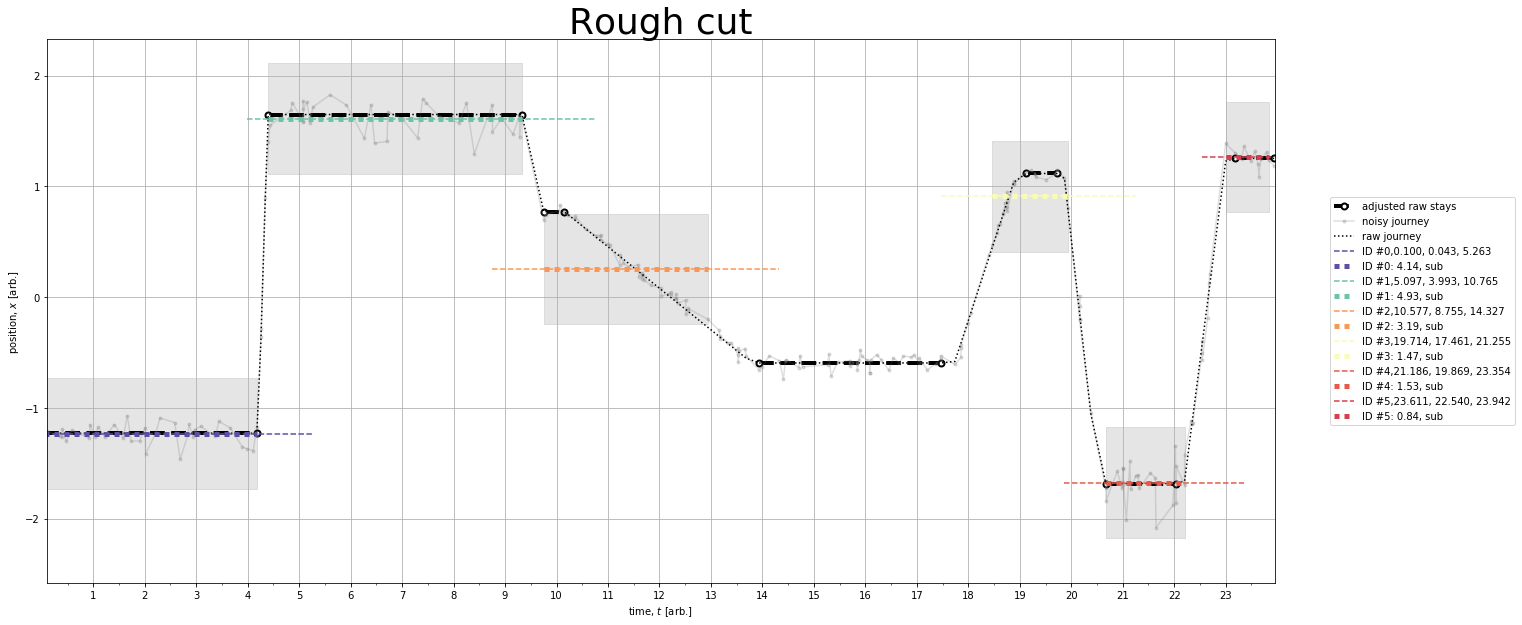

In [986]:
min_t, max_t = 0.1, 23.95

fig, ax = plt.subplots(1,1,figsize=(22,10))


# The adjusted raw-stays
plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
ax.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot(time_sub, raw_journey_sub, ':', color='k', label='raw journey')

t0,t1 = 0,1
start_ind, last_ind = t0, t1

pairs = []

nnn = 0

timepoint = min_t

while timepoint < max_t:
   
    # If the current timepoint is less than the last box-end, skip ahead
    # TODO: this is useful but possibly, without refinement, misses some stays 
    # HOWEVER: without it, it doesn't work!
    if (time_sub[start_ind] <= timepoint) & (timepoint <= time_sub[last_ind]):
        timepoint = timepoint+time_thresh
        
        print(f"\t\t\t {timepoint:.3f} already processed, skip")      
        continue    
    else:
        print(f"\nStart at {timepoint:.3f}, dt = {t_diff:.3f}, {t0}, {t1}")  
    
    # Process the time point
    mean, start_ind, last_ind = bug_asymm_box_method_modular(\
        time_sub,time_thresh,noise_journey_sub,eps,timepoint, 50, True)
    
    # Drop if a NAN was encountered --. failed to find a mean
    if np.isnan(mean):
        print("\t\t\tmean = NaN, skip")
        timepoint = time_sub[last_ind]+time_thresh
        continue
        
    # If the duration of the stay is too small, skip ahead
    if time_sub[last_ind]-time_sub[start_ind] < time_thresh:
        print("\t\t\ttoo short, skip") 
        timepoint = time_sub[last_ind]+time_thresh
        continue
    
    # If the duration due to the thresholded box is too short, skip ahead
    #print(start_ind,last_ind,mean)
    t0, t1 = get_thresh_duration2(eps, mean)(noise_journey_sub[start_ind:last_ind],start_ind)    
    #t0, t1 = get_thresh_duration(eps, mean)(noise_journey_sub[start_ind:last_ind],start_ind)  
    print(start_ind,last_ind,t0, t1)
    if time_sub[t1]-time_sub[t0] < time_thresh:
        print("\t\t\talso too short, skip")  
        timepoint = time_sub[t1]+time_thresh        
        continue  

    # If the stay is less than 1 hour, check the slope of the segement --> This isn't watertight
    if time_sub[t1]-time_sub[t0] < long_time_thresh:         
        xdata = time_sub[t0:t1]
        ydata = noise_journey_sub[t0:t1]
        slope = bug_get_slope(eps, mean)(xdata, ydata)
        print(f"\tAt {timepoint:.3f}, slope = {slope:.3f}")
        if abs(slope) > slope_thresh: 
            print("\t\t\tslope is too big, skip")
            timepoint = time_sub[t1]+time_thresh                    
            continue     
    # If the stay is less than 2 hour, check the slope of the segement
    if time_sub[t1]-time_sub[t0] < 2*long_time_thresh:                
        xdata = time_sub[t0:t1]
        ydata = noise_journey_sub[t0:t1]
        slope = bug_get_slope(eps, mean)(xdata, ydata)
        print(f"\tAgain, at {timepoint:.3f}, slope = {slope:.3f}")
        if abs(slope) > slope_thresh: 
            print("\t\t\tAgain, slope is too big, skip")
            timepoint = time_sub[t1]+time_thresh                        
            continue         
    
    # If the stay is embedded with other stays --> This is tricky!
    if any([embedded(t0,t1, p) for p in pairs] + [embedded(p[0],p[1],[t0,t1]) for p in pairs]):
        print("\t\t\tEmbedded, skip")   
        timepoint = time_sub[t1]+time_thresh                
        continue
    
    # PLOTTING
    dashing = "-"+23*" -"
    ddashing = "="+30*"=="
    
    t_start = time_sub[t0]
    t_last = time_sub[t1]
    
    '''seg_ind = min(3*nnn+1,len(new_t_segs))
    t_seg_0 = new_t_segs[seg_ind-1]
    t_seg_1 = new_t_segs[seg_ind]'''
    t_seg_0, t_seg_1 = check_true(t_start, t_last, new_t_segs)
    true_vals = ""
    if time_overlap(t_start, t_last, t_seg_0, t_seg_1 ):
        true_vals = f'{t_seg_0:2.3f}, {t_seg_1:2.3f}'    
    else:
        true_vals = 'Unmatched'
    true_vals = f"True: {true_vals};"

    print(f'\nPLOT: ID #{nnn:3d} {dashing}\n\t{timepoint:.3f}', \
          f'{t0}, {t1}', \
          true_vals,\
          f'Pred: {t_start:.3f}, {t_last:.3f}',\
          f'{mean:.3f}', \
          f'\n\n{ddashing}')
    #print(timepoint,":, mean, start_ind, last_ind)        
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean],\
            '--', color=colors[nnn], \
            label=f'ID #{nnn},{timepoint:.3f}, {time_sub[start_ind]:.3f}, {time_sub[last_ind]:.3f}')
    
    t_diff = abs(time_sub[t1]-time_sub[t0])
    ax.plot([time_sub[t0],time_sub[t1]], [mean,mean], '--', \
            dashes=[1,1], linewidth=5, color=colors[nnn], \
            label=f'ID #{nnn}: {round(t_diff,2)}, sub')
    
    # Add the box
    rect_color = "gray" #colors[nnn]
    rect = Rectangle((time_sub[t0], mean-eps), t_diff, 2*eps)
    pc = PatchCollection([rect], \
                         facecolor=rect_color, alpha=0.2, edgecolor=rect_color,linewidth=1)
    ax.add_collection(pc)

    #print(f"End At {timepoint:.3f}, dt = {t_diff:.3f}, {t0}, {t1}")   
    pairs.append([t0,t1])
    start_ind, last_ind = t0, t1
    
    timepoint = time_sub[t1]+time_thresh
    nnn += 1
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_journey_sub.min()-1*eps
ymax = noise_journey_sub.max()+1*eps
plt.ylim(ymin, ymax)


ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(min_t, max_t)
#plt.xlim(-0.1, 19.1)
#plt.xlim(15.1, 19.1)

plt.title('Rough cut', fontsize=36)
plt.grid(visible=True);
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right', ncol=1);

In [972]:
timepoint, timepoint-time_thresh

(9.743888888888888, 9.327222222222222)

In [973]:
start = np.where((time_sub < (timepoint)) & \
                 (time_sub > (timepoint-1*time_thresh)))

In [977]:
start[0].size

0

In [981]:
get_time_ind(time_sub, timepoint, time_thresh, 1)

74

In [980]:
time_sub[70:80]

array([ 8.93722222,  9.15416667,  9.28222222,  9.28222222,  9.32722222,
        9.75055556,  9.78722222, 10.05638889, 10.06638889, 10.13583333])

In [965]:
end = np.where((time_sub < (timepoint+time_thresh)) & \
               (time_sub > (timepoint)))[0].max() 
print(start,end)

ValueError: zero-size array to reduction operation minimum which has no identity

### Slope testing

In [871]:
slope = bug_get_slope(0.25, 1.2652784536739390)(time_sub[239:249], noise_journey_sub[239:249])

In [867]:
get_slope(time_sub[239:249], noise_journey_sub[239:249])

-0.18172501566805382

In [885]:
aaa,bbb = 181,201
meano = 0.9723058514956978

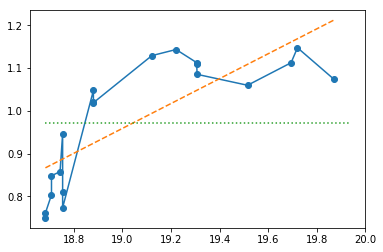

In [889]:
slope = bug_get_slope(0.25, meano)(time_sub[aaa:bbb], noise_journey_sub[aaa:bbb])

plt.plot(time_sub[aaa:bbb], noise_journey_sub[aaa:bbb], 'C0o-')
plt.plot(time_sub[aaa:bbb], slope*(time_sub[aaa:bbb]-time_sub[aaa:bbb].mean())+noise_journey_sub[aaa:bbb].mean(), 'C1--')
plt.plot([time_sub[aaa],time_sub[bbb]], [meano,meano], 'C2:')

### Test

In [ ]:
# DONE
def bug_extend_box(t_arr, x_loc, working_index, fixed_index, means, count_thresh = 50):

    keep_running = (working_index > 1) & (working_index < len(x_loc)-1)
    
    indices = []
    
    if working_index < fixed_index: 
        # Go backwards in time
        direction = -1
    else: 
        # Go forwards in time
        direction = 1
        
    mean = means[-1]
    while keep_running:
        #print(mean, direction)
        # Update and store the working index
        working_index += direction*1
        indices.append(working_index)
        
        # Update and store the mean
        if direction == -1:
            mean = get_thresh_mean(eps,mean)(x_loc[working_index:fixed_index])
        else:
            mean = get_thresh_mean(eps,mean)(x_loc[fixed_index:working_index])
        
        means.append(mean)    
        
        if np.isnan(mean):
            #print(mean)
            break
            
        time_diff = abs(t_arr[fixed_index]-t_arr[working_index])
        # When the mean either converges or stops
        if ((len(indices)>count_thresh) | ((time_diff>0.5) & (len(indices)>5))):  
            #print(time_diff,len(indices))
            nr_events = min(len(indices), count_thresh)
            if check_means(means,nr_events):
                #print('drop',time_diff)
                break       
                    
        keep_running = (working_index > 1) & (working_index < len(x_loc)-1)
        
    return means, indices, keep_running

In [705]:
# DONE
def bug_check_means(means,nr_samples,eps):
    m0 = means[-nr_samples]
    #TODO: or means could be less than 10% of eps
    #return all([m == m0 for m in means[-count_thresh:]])
    return all([abs(m - m0)<=eps/10 for m in means[-nr_samples:]])

In [757]:
ms, inds, flag = bbug_extend_box(time_sub, noise_journey_sub, 193, 177, [0.8226433365921534], 20)

19.305 0.838 0.085 1 177 194 	0.82264 1.113 1.07264
19.305 0.838 0.085 2 177 195 	0.82264 1.110 1.07264
19.307 0.840 0.087 3 177 196 	0.82264 1.085 1.07264
19.515 1.047 0.294 4 177 197 	0.82264 1.060 1.07264
19.694 1.226 0.000 5 177 198 	0.83846 1.113 1.08846
19.720 1.253 0.000 6 177 199 	0.87253 1.148 1.12253
19.869 1.401 0.000 7 177 200 	0.91241 1.075 1.16241
19.936 1.468 0.000 8 177 201 	0.98074 0.804 1.23074
20.163 1.695 0.000 9 177 202 	0.97231 -0.195 1.22231
20.163 1.695 0.000 10 177 203 	0.97231 0.010 1.22231
20.163 1.695 0.000 11 177 204 	0.97231 -0.083 1.22231
				valid  2:11
20.163 1.695 0.000 12 177 205 	0.97231 -0.208 1.22231
				valid  2:12
20.382 1.914 0.219 13 177 206 	0.97231 -1.045 1.22231
				valid  2:13
20.672 2.204 0.509 14 177 207 	0.97231 -1.726 1.22231
				valid  2:14
20.677 2.209 0.514 15 177 208 	0.97231 -1.838 1.22231
				valid  2:15
20.896 2.428 0.733 16 177 209 	0.97231 -1.574 1.22231
				valid  2:16
20.984 2.516 0.821 17 177 210 	0.97231 -1.725 1.22231
cdro

In [714]:
no_arr = noise_journey_sub[177:205]
ti_arr = time_sub[177:205]
bug_get_thresh_mean(eps,0.9807449844948974)(no_arr)

0.7307449844948974 1.2307449844948974
(array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24]),)


0.9723058514956978

In [683]:
get_thresh_mean(eps,0.9807449844948974)(no_arr)

0.9723058514956978

In [669]:
indl = [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24]
ti_arr[np.array(indl)], \
no_arr[np.array(indl)]

(array([18.68277778, 18.68277778, 18.70777778, 18.70777778, 18.74305556,
        18.75361111, 18.75361111, 18.75361111, 18.88027778, 18.88027778,
        18.88027778, 19.12083333, 19.22055556, 19.30527778, 19.30527778,
        19.30722222, 19.51472222, 19.69388889, 19.72027778, 19.86888889,
        19.93555556]),
 array([0.74976014, 0.76128752, 0.80363633, 0.84836305, 0.85800606,
        0.94659177, 0.81062394, 0.7735665 , 1.04773193, 1.01998489,
        1.01916894, 1.12926692, 1.14354958, 1.11291761, 1.10995569,
        1.0854763 , 1.05996262, 1.11263374, 1.1476734 , 1.07474276,
        0.80352319]))

In [675]:
# DONE
def bug_get_thresh_mean(eps, mean):
    
    upper = mean+eps
    lower = mean-eps
    print(lower,upper)
    def meth(sub_arr):
        
        mask =  np.where((sub_arr < upper) & (sub_arr > lower))
        print(mask)
        return np.mean(sub_arr[mask])
        
    return meth

In [617]:
ms, inds

([0.8226433365921534,
  0.8226433365921534,
  0.8226433365921534,
  0.8226433365921534,
  0.8226433365921534,
  0.8384646219473202,
  0.8725266093654495,
  0.912411454775526,
  0.9807449844948974,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978,
  0.9723058514956978],
 [194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221])

In [993]:
def func(in_):
    print(in_)
    return in_, out=False

SyntaxError: invalid syntax (<ipython-input-993-11cd88d5af3b>, line 3)